In [1]:
from functools import partial
import logging
import pandas as pd, dask.dataframe as dd
from scipy.stats.mstats import winsorize
import numpy as np
from empyrical import sharpe_ratio

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (28, 6)
plt.style.use("ggplot")

from utils import stationarity_test
from residualisation import rolling_df_to_series, fa_residualise, pca_residualise
from preprocessing import preprocess_ou

logger = logging.getLogger(__name__)    

## Computing Raw Residuals

First we compute raw residuals using PCA and Factor Analysis across the entire universe of crypto pairs. The idea is that these residuals represent "mispricings" of the pairs, and we can then go long the most negative residuals and short the most positive residuals as a trading strategy. We compute rolling out-of-sample residuals with daily fitting, and run this for several different `n_components`.

In [2]:
WINDOW = 100
N_COMPONENTS_TUPLE = (3, 5, 10, 20)

In [3]:
USECOLS = ("time", "open", "close", "high", "low", "volume", "pair_name", "date")

In [4]:
data = dd.read_csv("data/*", usecols=USECOLS)

daily_volumes = data.groupby(["date", "pair_name"]).sum().compute()
daily_volumes = daily_volumes.reset_index().pivot(values="volume", index="date", columns="pair_name")
daily_volumes.index = pd.to_datetime(daily_volumes.index)

daily_prices = data.groupby(["date", "pair_name"]).last().compute()
daily_prices = daily_prices.reset_index().pivot(values="close", index="date", columns="pair_name")
daily_prices.index = pd.to_datetime(daily_prices.index)

We winsorize the dataframe of returns to reduce the impact of outliers. We do this once over the whole history, with the expectation that this should not lead to any major biases.

In [13]:
def winsorize_df(df, quantile):
    """Apply winsorization to a dataframe."""
    wins = winsorize(df.values, limits=(quantile, quantile))
    return pd.DataFrame(wins, columns=df.columns, index=df.index)

In [14]:
daily_returns = daily_prices.pct_change()
daily_returns = winsorize_df(daily_returns, quantile=0.01)
daily_log_returns = np.log(1 + daily_returns)

We perform an ADF test on all pairs with at least a years' (252 days') worth of data: 

<AxesSubplot: xlabel='pair_name'>

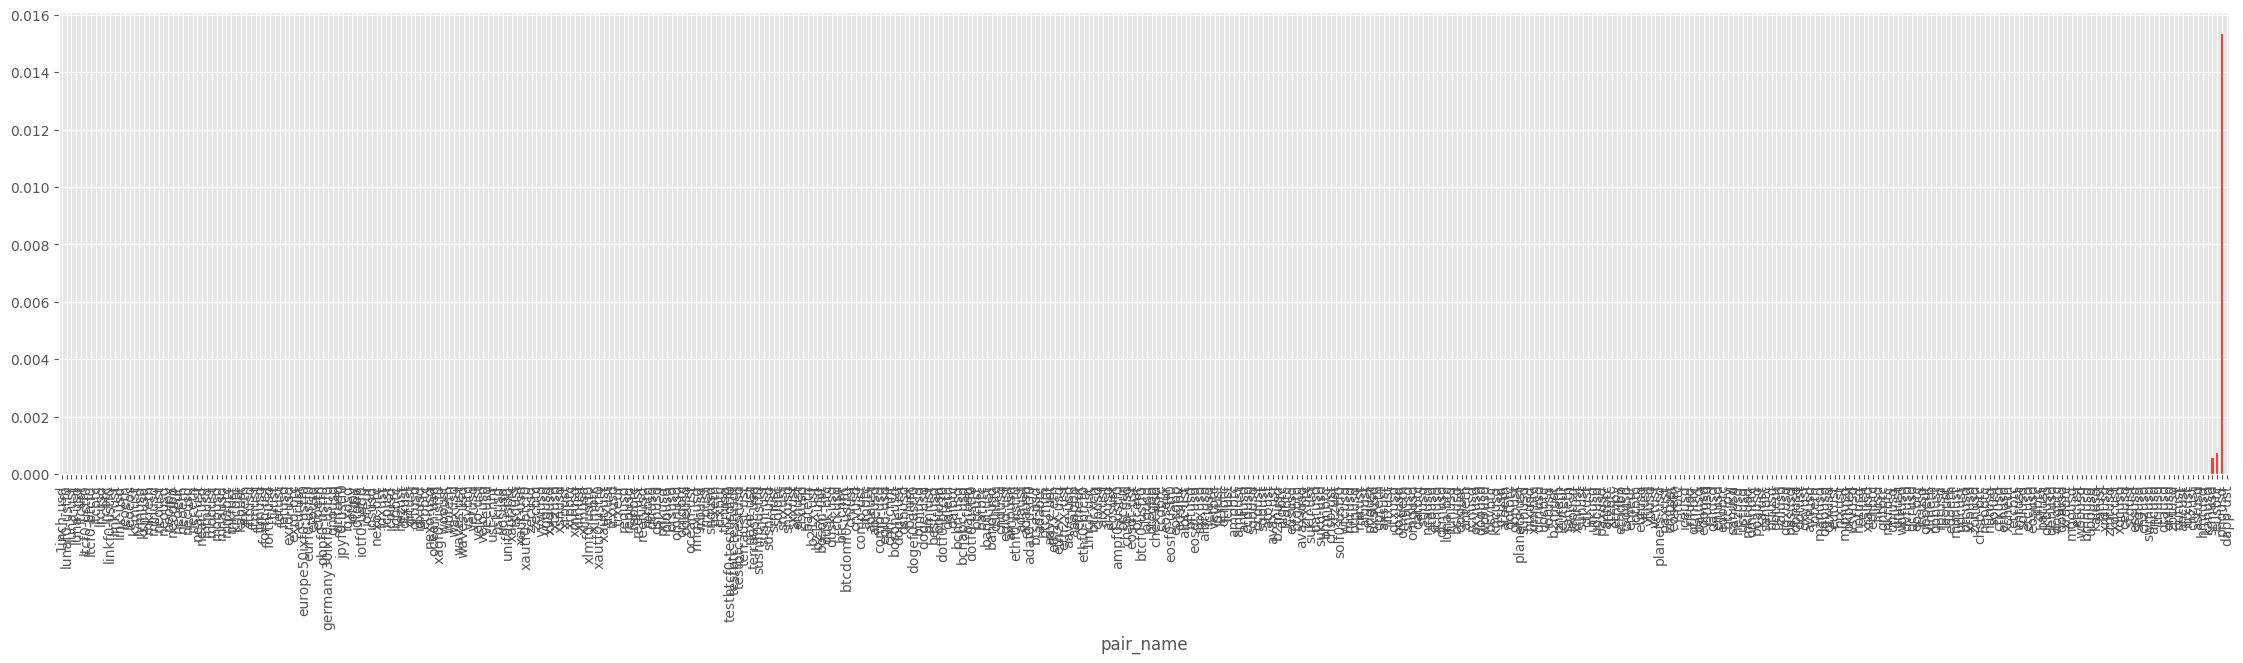

In [15]:
adf_pvals = daily_log_returns.loc[:, daily_log_returns.count() >= 252].apply(stationarity_test)
adf_pvals.sort_values().plot.bar()

A few pairs indicate nonstationarity but these are very few, and the vast majority would be rejected (i.e. concluded stationary) using Bonferroni correction for multiple testing. So we proceed with all pairs. As expected, the universe increases in size over time:

<AxesSubplot: xlabel='date'>

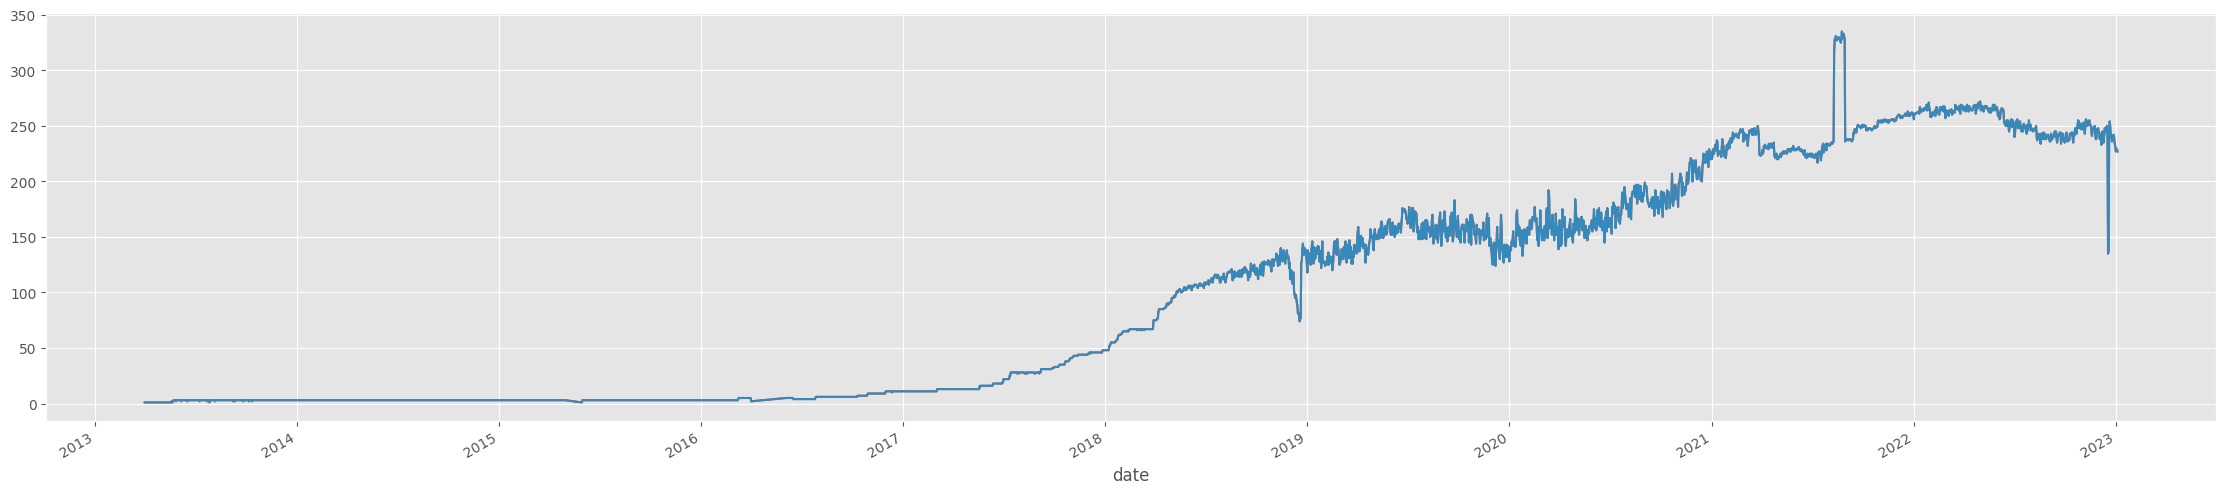

In [16]:
daily_prices.count(axis=1).plot(label="prices")
daily_volumes.count(axis=1).plot(label="volumes")

To avoid survivorship/hindsight bias, we filter the pairs based on the top 150 in terms of average daily trading volume:

In [17]:
adtv_filter = (daily_volumes.shift().rolling(252, 10).median().rank(axis=1, ascending=False) <= 150).fillna(False)

We see that we consistently have 150 pairs in our universe from 2019 onwards:

<AxesSubplot: xlabel='date'>

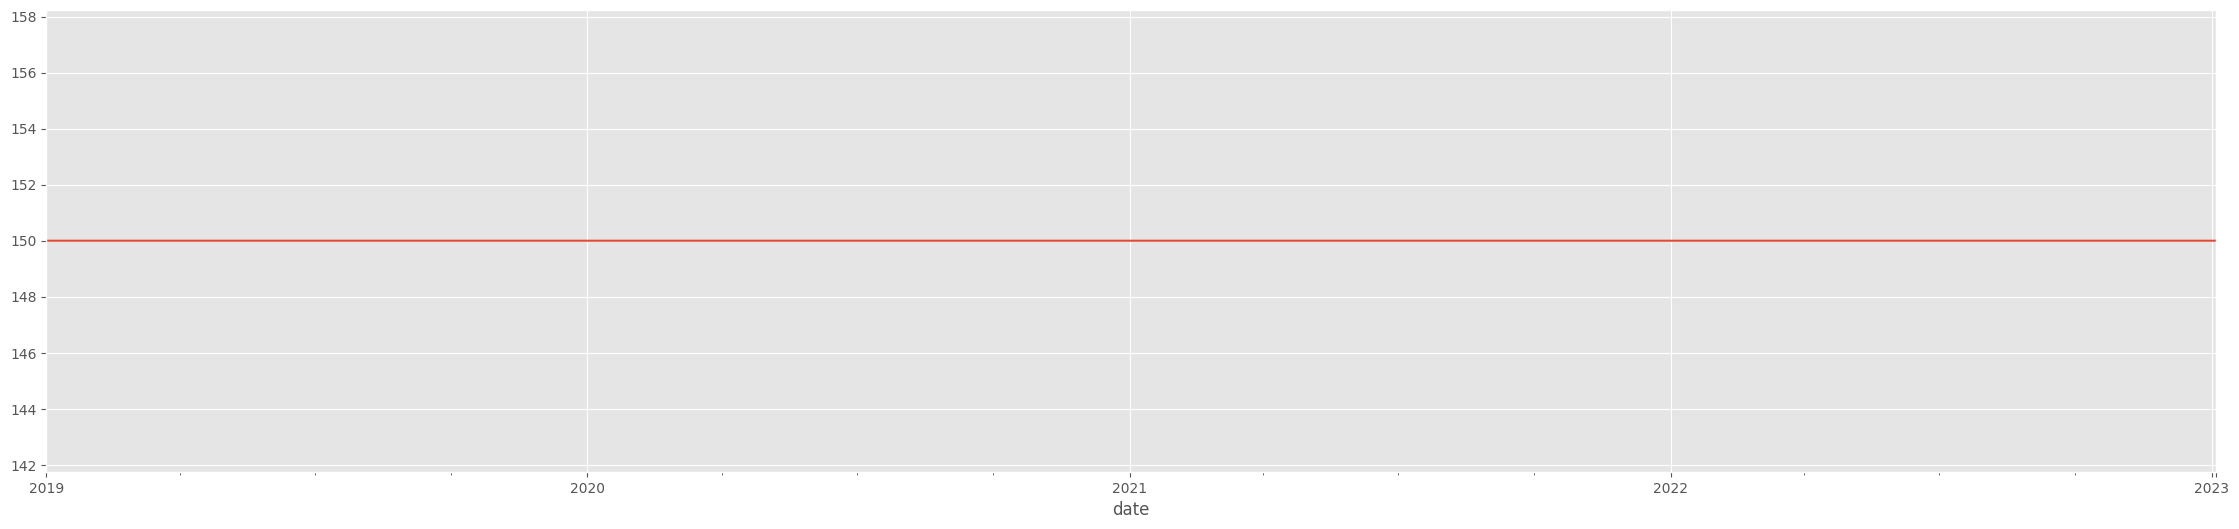

In [18]:
daily_prices.ffill().where(adtv_filter).count(axis=1)["2019-01-01":].plot()

Since we will only consider 2019 onwards, we reduce the history of the daily returns.

In [19]:
daily_returns = daily_returns.loc["2018-06-01":].copy()
daily_log_returns = daily_log_returns.loc["2018-06-01":].copy()

In [44]:
fa_fns = {n_cpt: partial(fa_residualise, n_components=n_cpt) for n_cpt in N_COMPONENTS_TUPLE}
pca_fns = {n_cpt: partial(pca_residualise, n_components=n_cpt) for n_cpt in N_COMPONENTS_TUPLE}

fa_residuals = {n_cpt: rolling_df_to_series(daily_log_returns, fn, window=WINDOW) for n_cpt, fn in fa_fns.items()}
pca_residuals = {n_cpt: rolling_df_to_series(daily_log_returns, fn, window=WINDOW) for n_cpt, fn in pca_fns.items()}

100%|██████████| 1579/1579 [00:47<00:00, 33.06it/s]


We note here that a useful evaluation metric for how well the model works is to compute a rolling Spearman correlation between the negative residuals and the returns, for each pair separately, and then take a mean across the cross-section to get a daily rolling evaluation score. This score makes sense intuitively as we believe that the order of the residuals should correspond to

In [34]:
def sp_score(residuals, future_returns=daily_returns.shift(-1), adtv_filter=adtv_filter, window=252):
    # FIXME: does method="spearman" do anything when applied to rolling object?
    rolling_corrs = (- residuals).rolling(window, window // 2).corr(future_returns, method="spearman")
    return rolling_corrs.where(adtv_filter).mean(axis=1)

## Preprocessing Raw Residuals

We can preprocess the raw residuals by fitting the Ornstein-Uhlenbeck process to each series on a rolling basis. This is a mean-reverting model, and returns "s-scores" as defined here: https://www.math.nyu.edu/~avellane/AvellanedaLeeStatArb071108.pdf. We can go long-short on these s-scores instead of the raw residuals, and evaluate in the same way.

In [35]:
fa_ou_residuals = {n_cpt: rolling_df_to_series(res, preprocess_ou, window=WINDOW) for n_cpt, res in fa_residuals.items()}
pca_ou_residuals = {n_cpt: rolling_df_to_series(res, preprocess_ou, window=WINDOW) for n_cpt, res in pca_residuals.items()}

100%|██████████| 1579/1579 [00:01<00:00, 1264.99it/s]


## Evaluation

We now evaluate the residuals constructed, by comparing Spearman correlations, returns series, and Sharpe ratios.

In [36]:
N_PER_SIDE = 25  # how many stocks to go long and short per day

In [37]:
def long_short(residuals, n_per_side):
    long = (residuals.rank(axis=1) <= n_per_side) * 1
    short = (residuals.rank(axis=1, ascending=False) <= n_per_side) * 1
    return long - short


def get_signal_returns(residuals, adtv_filter=adtv_filter, daily_returns=daily_returns, n_per_side=N_PER_SIDE):
    ls = long_short(residuals.where(adtv_filter), n_per_side=n_per_side)
    future_returns = daily_returns.shift(-1) 
    return (ls * future_returns).mean(axis=1)

### Raw residuals

In [38]:
fa_rolling_scores = {n_cpt: sp_score(res) for n_cpt, res in fa_residuals.items()}
pca_rolling_scores = {n_cpt: sp_score(res) for n_cpt, res in pca_residuals.items()}

In [39]:
fa_returns = {n_cpt: get_signal_returns(res) for n_cpt, res in fa_residuals.items()}
pca_returns = {n_cpt: get_signal_returns(res) for n_cpt, res in pca_residuals.items()}

In [40]:
fa_srs = {n_cpt: sharpe_ratio(rets) for n_cpt, rets in fa_returns.items()}
pca_srs = {n_cpt: sharpe_ratio(rets) for n_cpt, rets in pca_returns.items()}

In [41]:
fa_best = pd.Series(fa_srs).sort_values(ascending=False).index[0]
pca_best = pd.Series(pca_srs).sort_values(ascending=False).index[0]

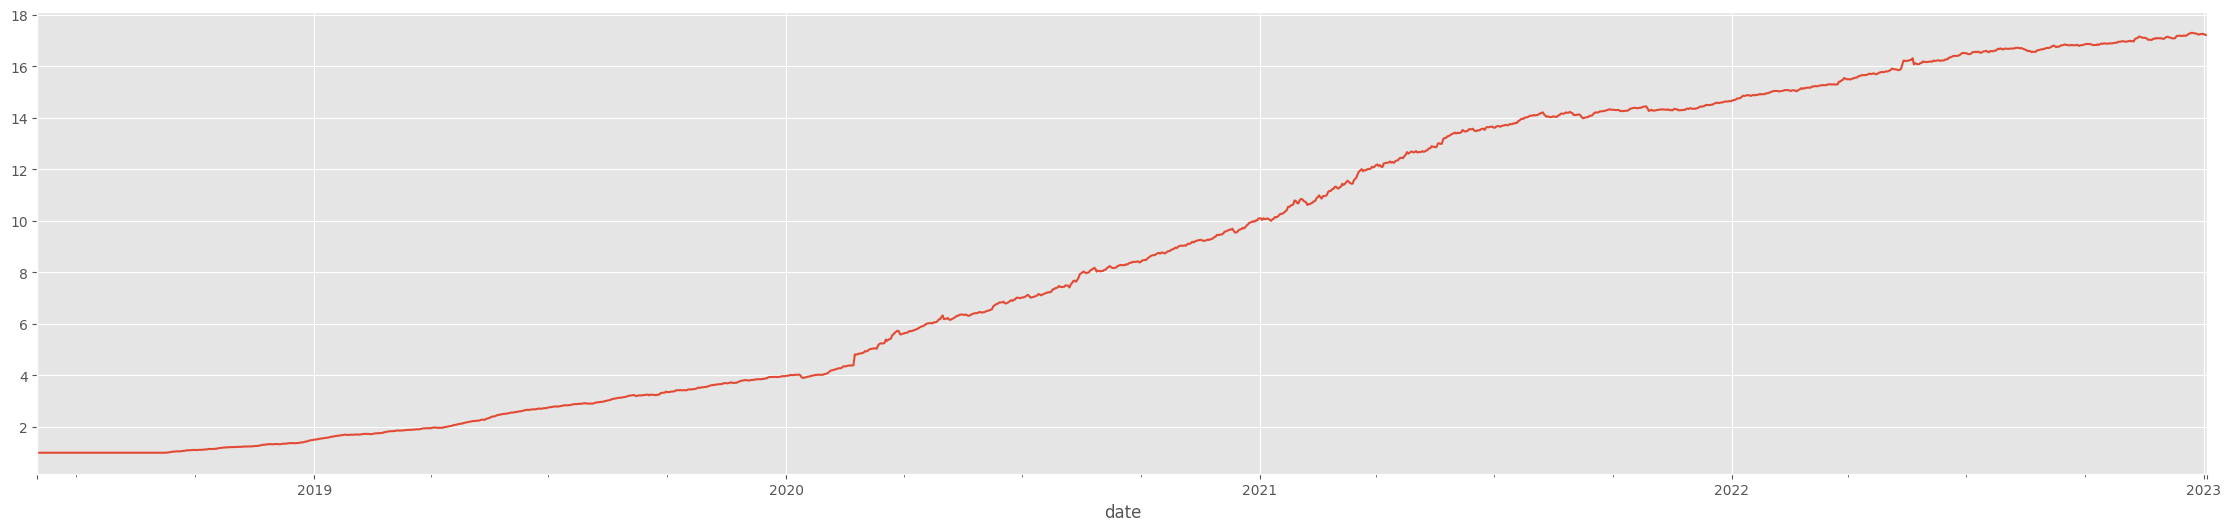

In [42]:
logger.info(f"Best number of components for FA is {fa_best}.")
_ = (fa_returns[fa_best] + 1).cumprod().plot()

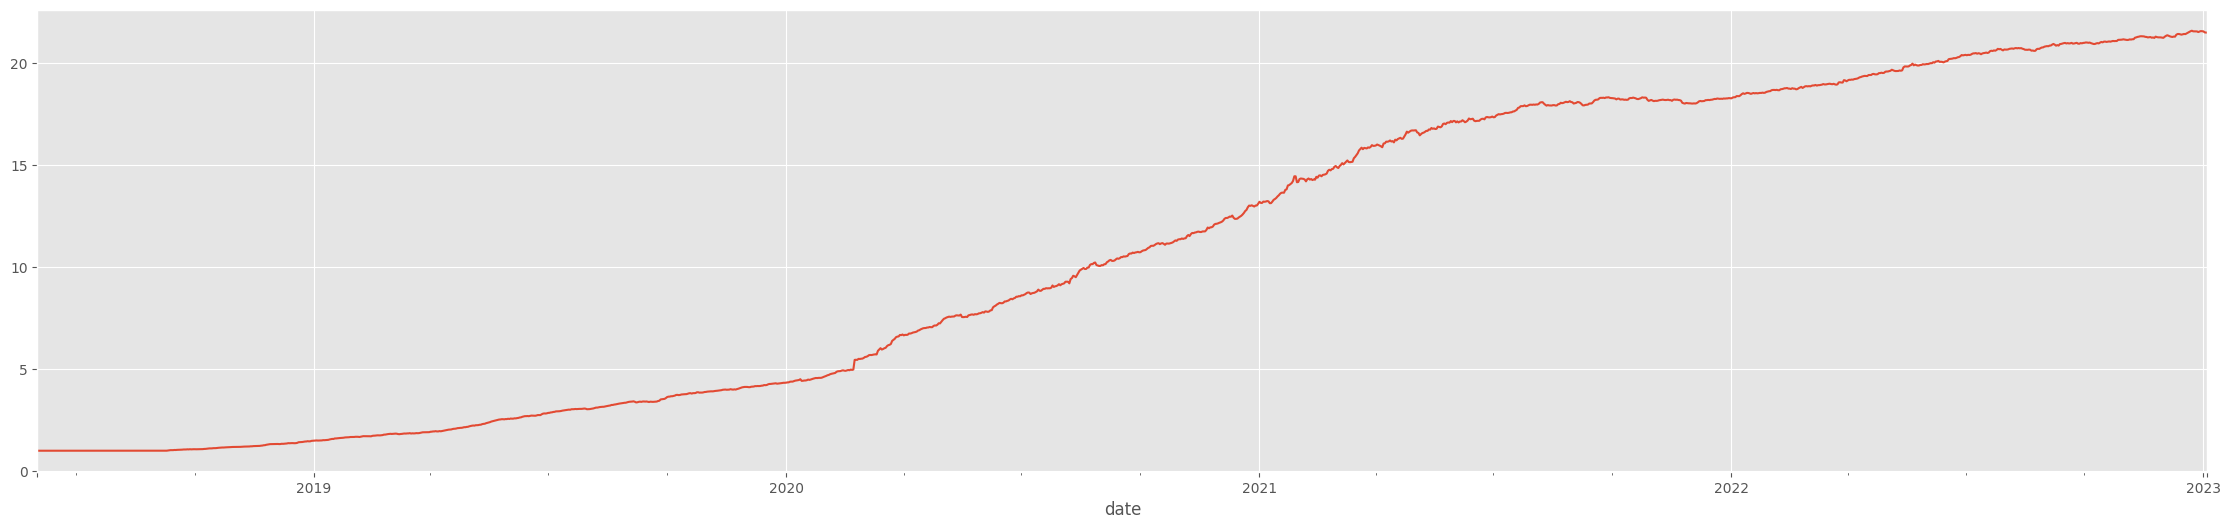

In [43]:
logger.info(f"Best number of components for PCA is {pca_best}.")
_ = (pca_returns[pca_best] + 1).cumprod().plot()

In [44]:
fa_srs[fa_best]

6.1834591574401045

In [45]:
pca_srs[pca_best]

6.658407857536208

### Ornstein-Uhlenbeck residuals

In [46]:
fa_ou_rolling_scores = {n_cpt: sp_score(res) for n_cpt, res in fa_ou_residuals.items()}
pca_ou_rolling_scores = {n_cpt: sp_score(res) for n_cpt, res in pca_ou_residuals.items()}

In [47]:
fa_ou_returns = {n_cpt: get_signal_returns(res) for n_cpt, res in fa_ou_residuals.items()}
pca_ou_returns = {n_cpt: get_signal_returns(res) for n_cpt, res in pca_ou_residuals.items()}

In [48]:
fa_ou_srs = {n_cpt: sharpe_ratio(rets) for n_cpt, rets in fa_ou_returns.items()}
pca_ou_srs = {n_cpt: sharpe_ratio(rets) for n_cpt, rets in pca_ou_returns.items()}

In [49]:
fa_ou_best = pd.Series(fa_ou_srs).sort_values(ascending=False).index[0]
pca_ou_best = pd.Series(pca_ou_srs).sort_values(ascending=False).index[0]

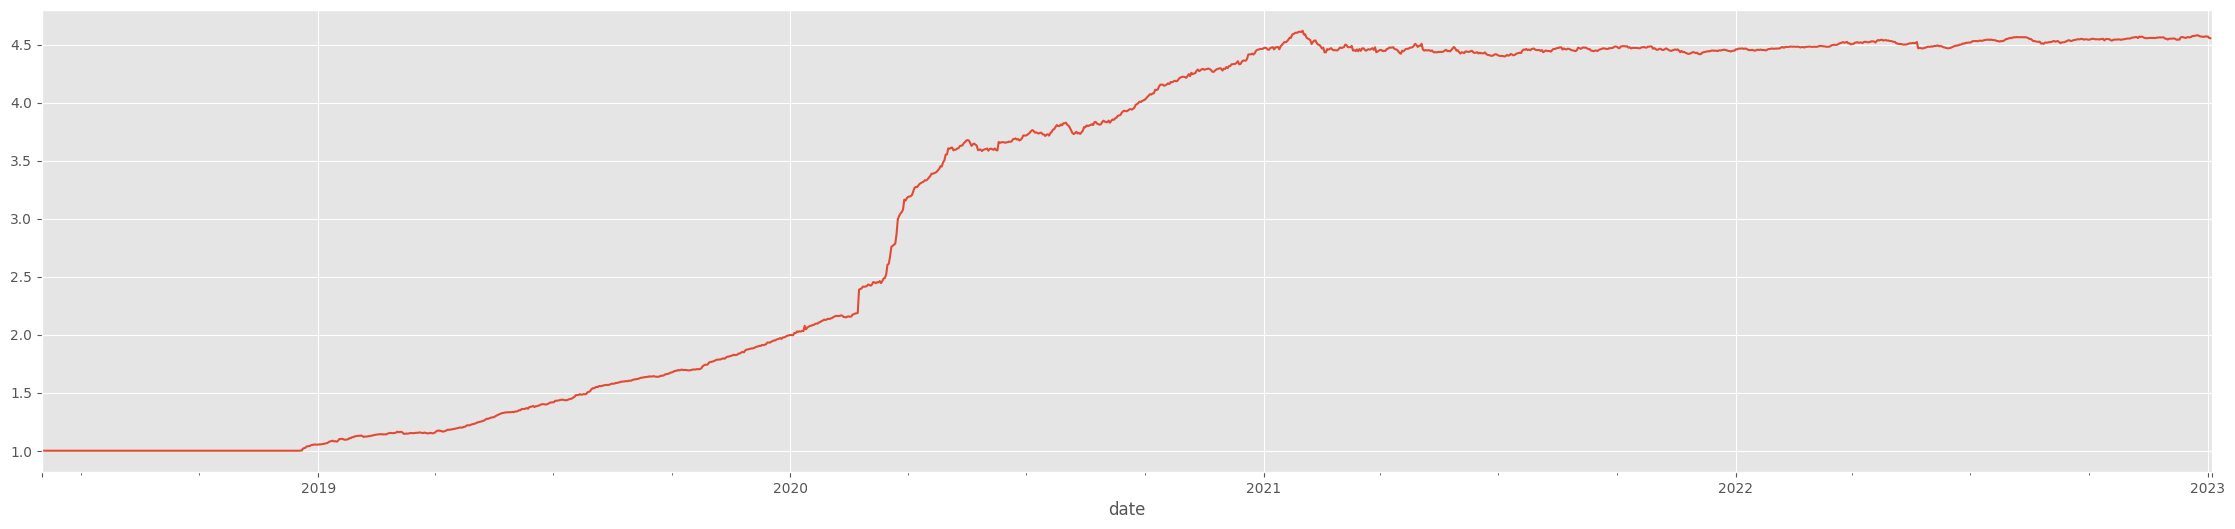

In [50]:
logger.info(f"Best number of components for OU FA is {fa_ou_best}.")
_ = (fa_ou_returns[fa_ou_best] + 1).cumprod().plot()

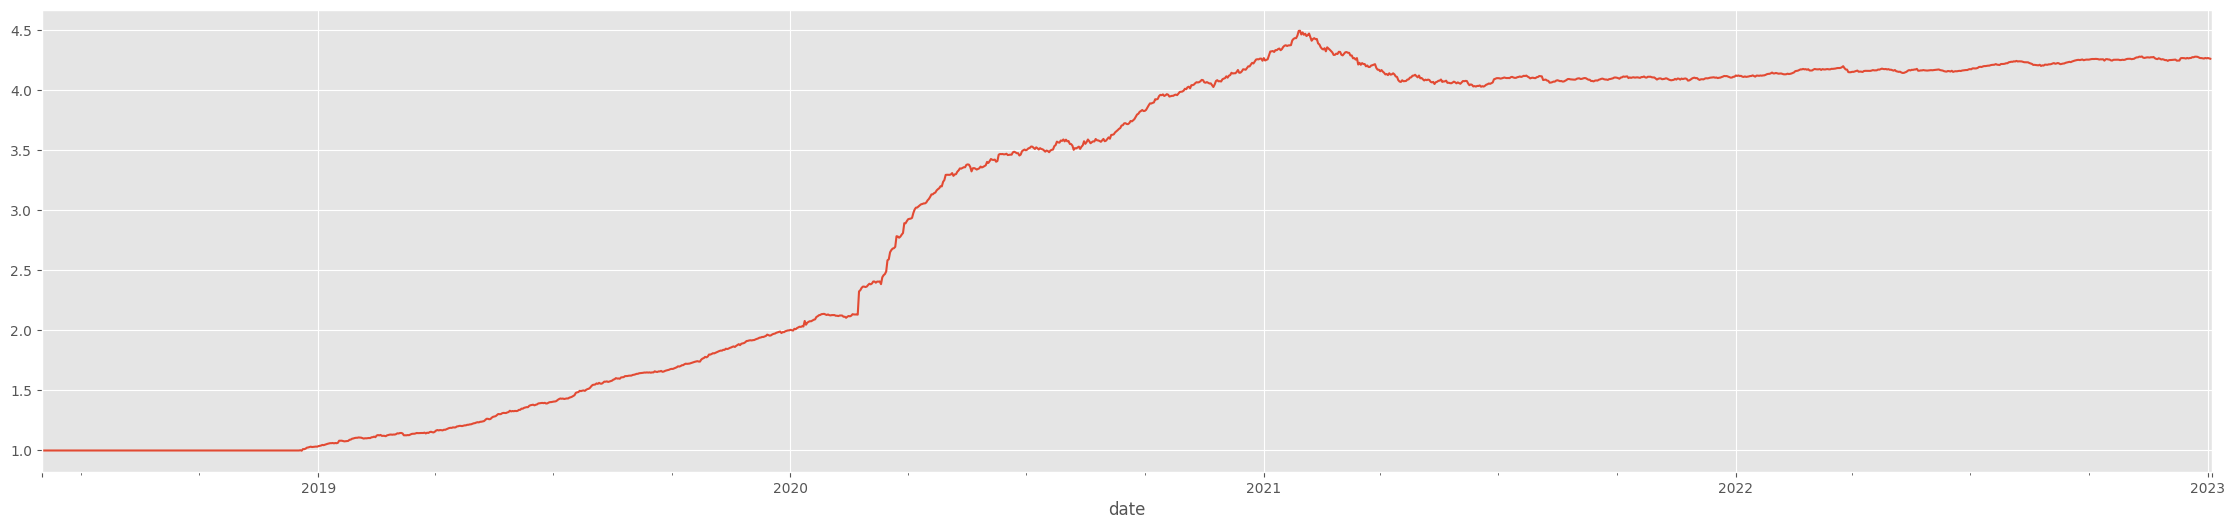

In [51]:
logger.info(f"Best number of components for OU PCA is {pca_ou_best}.")
_ = (pca_ou_returns[pca_ou_best] + 1).cumprod().plot()

In [52]:
fa_ou_srs[fa_ou_best]

3.66775115820496

In [53]:
pca_ou_srs[pca_ou_best]

3.594943904637492

Of course, these trading strategies are highly unrealistic: no trading fees are accounted for, nor is there any analysis of capacity / market impact, for example.